In [1]:
import gym
import numpy as np
import pandas as pd
from math import inf
import math
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [3]:
# create the device object
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Cart Pole environment

In [4]:
# cart pole environment
cp_env = gym.make('CartPole-v0')
cp_env.reset()

# action_space
cp_action_space = [0,1]

## Implementation

This function selects an action using e-greedy policy for a given q_hat

In [5]:
# action selection with epsilon greed policy
def e_greedy(q_hat, eps, S, action_space):
    # random action with probability eps
    if np.random.random() < eps:
        return np.random.choice(action_space)
    
    # greedy action otherwise
    act_vals = np.array([q_hat(feature(S,a)).cpu().detach().numpy() for a in action_space])
    
    return np.random.choice(np.where(act_vals == act_vals.max())[0])

In [6]:
# decay function for epsilon
def decay_eps(current_eps, eps_min, eps_dec):
    new_eps = current_eps - eps_dec
    return max(new_eps, eps_min)

In [7]:
# create input feature from state and action
def feature(s,a):
    np_feature = np.append(s,a)
    return torch.from_numpy(np_feature).float().to(dev)

### Neural Network model to represent the action-value function

In [8]:
class NeuralNet(nn.Module):
    '''
    input layer: no of nueron = input size (length of state space + 1 (action))
    hidden layers: 2 layers 32 and 16 neurons respectively with ReLU activation
    output layer: 1 neuron (representing the value of state-action pair)
    '''
    def __init__(self, input_size, hidden_size_1 = 32, hidden_size_2 = 16):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size_1)
        self.activation1 = nn.ReLU()
        self.l2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.activation2 = nn.ReLU()
        self.l3 = nn.Linear(hidden_size_2, 1)
        
    def forward(self, X):
        pred = self.l1(X)
        pred = self.activation1(pred)
        pred = self.l2(pred)
        pred = self.activation2(pred)
        pred = self.l3(pred)
        return pred

In [9]:
# size of input layer
cp_input_size  = cp_env.observation_space.shape[0] + 1

# Neural net as a paramatric function to approximate action-value function Q
cp_q_hat = NeuralNet(cp_input_size, hidden_size_1 = 32, hidden_size_2 = 16)
cp_q_hat.to(dev)

# adam optimiser with learning rate of 0.005
optimiser = optim.Adam(cp_q_hat.parameters(), lr = 0.005)

### Episodic semi-gradient n-step SARSA

In [10]:
def n_step_sarsa(env, action_space, q_hat, opt,
                 max_episodes = 50000, GAMMA = 1.0,
                 EPS_MAX = 1.0, EPS_MIN = 0.05, n=1,
                 loss_fn = nn.MSELoss()):
    
    # set seed for reproducible results
    env.seed(0)
    np.random.seed(0)
    
    # epsilon decay per episode
    eps_dec = (EPS_MAX - EPS_MIN)*2/max_episodes
    eps = EPS_MAX

    scores = []

    for episode in range(max_episodes):
        T = inf
        t = 0

        # storage
        states = [0]*(n+1)
        actions = [0]*(n+1)
        rewards = [0]*(n+1)

        # initialize S and store
        S = env.reset()
        states[t % (n+1)] = S

        # choose A and store
        A = e_greedy(q_hat, eps, S, action_space)
        actions[t % (n+1)] = A

        score = 0
        while True:
            if t < T:
                # take action A, observe R and S_next
                S, R, done, _ = env.step(A)

                score += R

                # store R and S_next
                rewards[(t+1) % (n+1)] = R
                states[(t+1) % (n+1)] = S

                if done:
                    T = t + 1
                else:
                    # choose and store A_next
                    A = e_greedy(q_hat, eps, S, action_space)
                    actions[(t+1) % (n+1)] = A

            tau = t - n + 1
            if tau >= 0:
                # compute the target G
                G = [GAMMA**(i-tau-1)*rewards[i % (n+1)]
                     for i in range(tau+1, min(tau+n, T) + 1)]
                G = [np.sum(G)]
                if tau + n < T:
                    s = states[(tau+n) % (n+1)]
                    a = actions[(tau+n) % (n+1)]
                    G += (GAMMA**n) * (q_hat(feature(s,a)).cpu().detach().numpy())
                G = torch.tensor(G).float().to(dev)

                s = states[tau % (n+1)]
                a = actions[tau % (n+1)]
                # predict the value
                pred = q_hat(feature(s,a))
                # compute gradient
                loss = loss_fn(pred, G)
                loss.backward()
                # update the params
                opt.step()
                opt.zero_grad()             
                
            t += 1
            if tau == T - 1:
                break
        
        # decay the epsilon 
        eps = decay_eps(eps, EPS_MIN, eps_dec)
        
        scores.append(score)
        avg_score = np.mean(scores[-100:])
        
        if episode % 100 == 0:
            print('episode:', episode, '| avg_reward for last 100 episodes: %.1f' % avg_score)
            
    return q_hat, scores

In [11]:
q_hat_1_step_sarsa, rewards_1_step_sarsa = n_step_sarsa(env = cp_env, 
                                                        action_space = cp_action_space,
                                                        q_hat = cp_q_hat, opt = optimiser,
                                                        max_episodes = 2000,
                                                        n=1)

episode: 0 | avg_reward for last 100 episodes: 22.0
episode: 100 | avg_reward for last 100 episodes: 23.1
episode: 200 | avg_reward for last 100 episodes: 30.9
episode: 300 | avg_reward for last 100 episodes: 40.1
episode: 400 | avg_reward for last 100 episodes: 56.7
episode: 500 | avg_reward for last 100 episodes: 97.9
episode: 600 | avg_reward for last 100 episodes: 128.6
episode: 700 | avg_reward for last 100 episodes: 145.3
episode: 800 | avg_reward for last 100 episodes: 100.0
episode: 900 | avg_reward for last 100 episodes: 160.9
episode: 1000 | avg_reward for last 100 episodes: 170.7
episode: 1100 | avg_reward for last 100 episodes: 141.2
episode: 1200 | avg_reward for last 100 episodes: 144.0
episode: 1300 | avg_reward for last 100 episodes: 121.0
episode: 1400 | avg_reward for last 100 episodes: 19.3
episode: 1500 | avg_reward for last 100 episodes: 15.4
episode: 1600 | avg_reward for last 100 episodes: 15.4
episode: 1700 | avg_reward for last 100 episodes: 13.6
episode: 1800 

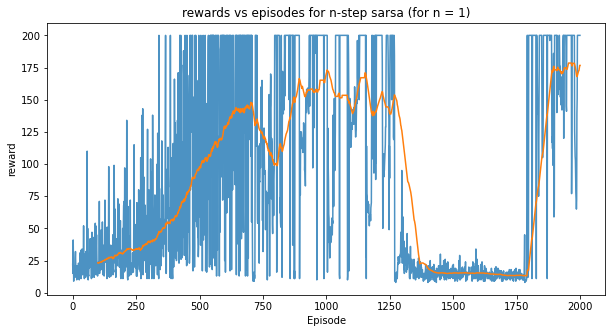

In [12]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_1_step_sarsa)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for n-step sarsa (for n = 1)')
plt.show()

### performance test

In [13]:
def test(q_hat, eps, action_space, num_episodes = 1000):
    rewards = np.zeros(num_episodes)
    for i in range(num_episodes):
        totalReward = 0
        observation  = cp_env.reset()
        done = False
        while not done:
            action =  e_greedy(q_hat, eps, observation, action_space)
            observation, reward, done, info = cp_env.step(action)
            totalReward += reward
        rewards[i] = totalReward
    
    print(f"Average reward over {num_episodes} episodes: {np.average(rewards):.2f}")
    
    plt.figure(2, figsize=[10,5])
    plt.plot(rewards)
    plt.xlabel('episode number')
    plt.ylabel('reward')
    plt.show()

Average reward over 100 episodes: 200.00


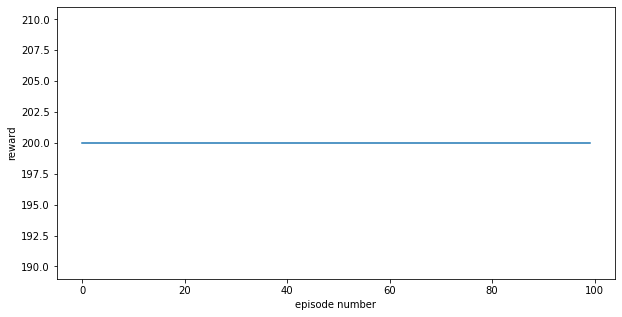

In [14]:
# test the learned policy
test(q_hat_1_step_sarsa, 0, cp_action_space, 100 )